In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '50-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 16 * 8,
  "EPOCHS": 12,
  "LEARNING_RATE": 2e-5 * 8,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.00016,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00016 to 4.19e-05


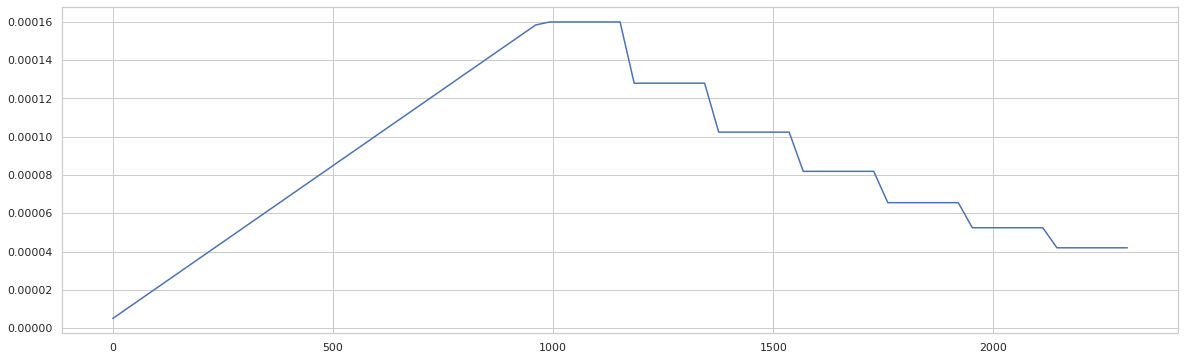

In [11]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [13]:
# Evaluation
# eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=512, buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
# test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
# test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=512, buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/12
194/194 - 97s - auc: 0.5305 - loss: 0.3904 - val_auc: 0.7025 - val_loss: 0.1840
Epoch 2/12
194/194 - 72s - auc: 0.7205 - loss: 0.1753 - val_auc: 0.7955 - val_loss: 0.1681
Epoch 3/12
194/194 - 72s - auc: 0.8139 - loss: 0.1686 - val_auc: 0.8442 - val_loss: 0.1656
Epoch 4/12
194/194 - 72s - auc: 0.8313 - loss: 0.1673 - val_auc: 0.8779 - val_loss: 0.1630
Epoch 5/12
194/194 - 67s - auc: 0.8455 - loss: 0.1660 - val_auc: 0.8564 - val_loss: 0.1640
Epoch 6/12
194/194 - 72s - auc: 0.8786 - loss: 0.1635 - val_auc: 0.8694 - val_loss: 0.1628
Epoch 7/12
194/194 - 73s - auc: 0.9108 - loss: 0.1610 - val_auc: 0.8769 - val_loss: 0.1621
Epoch 8/12
194/194 - 67s - auc: 0.9274 - loss: 0.1578 - val_auc: 0.8953 - val_loss: 0.1626
Epoch 9/12
194/194 - 67s - auc: 0.9298 - loss: 0.1544 - val_auc: 0.8810 - val_loss: 0.1654
Epoch 10/12
194/194 - 67s - auc: 0.9403 - loss: 0.1524 - val_auc: 0.8598 - val_loss: 0.1629
Epoch 11/12
194/194 - 

INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 101s - auc: 0.5296 - loss: 0.3787 - val_auc: 0.7104 - val_loss: 0.1777
Epoch 2/12
210/210 - 77s - auc: 0.7487 - loss: 0.1725 - val_auc: 0.8209 - val_loss: 0.1683
Epoch 3/12
210/210 - 76s - auc: 0.8130 - loss: 0.1690 - val_auc: 0.8652 - val_loss: 0.1648
Epoch 4/12
210/210 - 71s - auc: 0.8286 - loss: 0.1665 - val_auc: 0.8649 - val_loss: 0.1651
Epoch 5/12
210/210 - 76s - auc: 0.8618 - loss: 0.1660 - val_auc: 0.8822 - val_loss: 0.1621
Epoch 6/12
210/210 - 77s - auc: 0.8817 - loss: 0.1622 - val_auc: 0.8916 - val_loss: 0.1611
Epoch 7/12
210/210 - 78s - auc: 0.9062 - loss: 0.1606 - val_auc: 0.9010 - val_loss: 0.1604
Epoch 8/12
210/210 - 78s - auc: 0.9135 - loss: 0.1582 - val_auc: 0.9022 - val_loss: 0.1593
Epoch 9/12
210/210 - 71s - auc: 0.9343 - loss: 0.1563 - val_auc: 0.9028 - val_loss: 0.1617
Epoch 10/12
210/210 - 71s - auc: 0.9416 - loss: 0.1529 - val_auc: 0.8938 - val_loss: 0.1615
Epoch 11/12
210/210 - 71s - auc: 0.9479 - loss: 0.1502 - val_auc: 0.9119 - val_loss: 0.1

INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.163.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 101s - auc: 0.5270 - loss: 0.3791 - val_auc: 0.7420 - val_loss: 0.1787
Epoch 2/12
210/210 - 76s - auc: 0.7406 - loss: 0.1729 - val_auc: 0.8284 - val_loss: 0.1705
Epoch 3/12
210/210 - 76s - auc: 0.8121 - loss: 0.1678 - val_auc: 0.8444 - val_loss: 0.1674
Epoch 4/12
210/210 - 76s - auc: 0.8425 - loss: 0.1671 - val_auc: 0.8825 - val_loss: 0.1654
Epoch 5/12
210/210 - 77s - auc: 0.8745 - loss: 0.1646 - val_auc: 0.8898 - val_loss: 0.1643
Epoch 6/12
210/210 - 71s - auc: 0.8841 - loss: 0.1624 - val_auc: 0.8773 - val_loss: 0.1644
Epoch 7/12
210/210 - 77s - auc: 0.9090 - loss: 0.1599 - val_auc: 0.8969 - val_loss: 0.1603
Epoch 8/12
210/210 - 71s - auc: 0.9227 - loss: 0.1559 - val_auc: 0.8667 - val_loss: 0.1605
Epoch 9/12
210/210 - 71s - auc: 0.9382 - loss: 0.1549 - val_auc: 0.8751 - val_loss: 0.1640
Epoch 10/12
210/210 - 71s - auc: 0.9426 - loss: 0.1526 - val_auc: 0.8742 - val_loss: 0.1620
Epoch 11/12
210/210 - 71s - auc: 0.9527 - loss: 0.1501 - val_auc: 0.8805 - val_loss: 0.1

## Model loss graph

Fold: 1


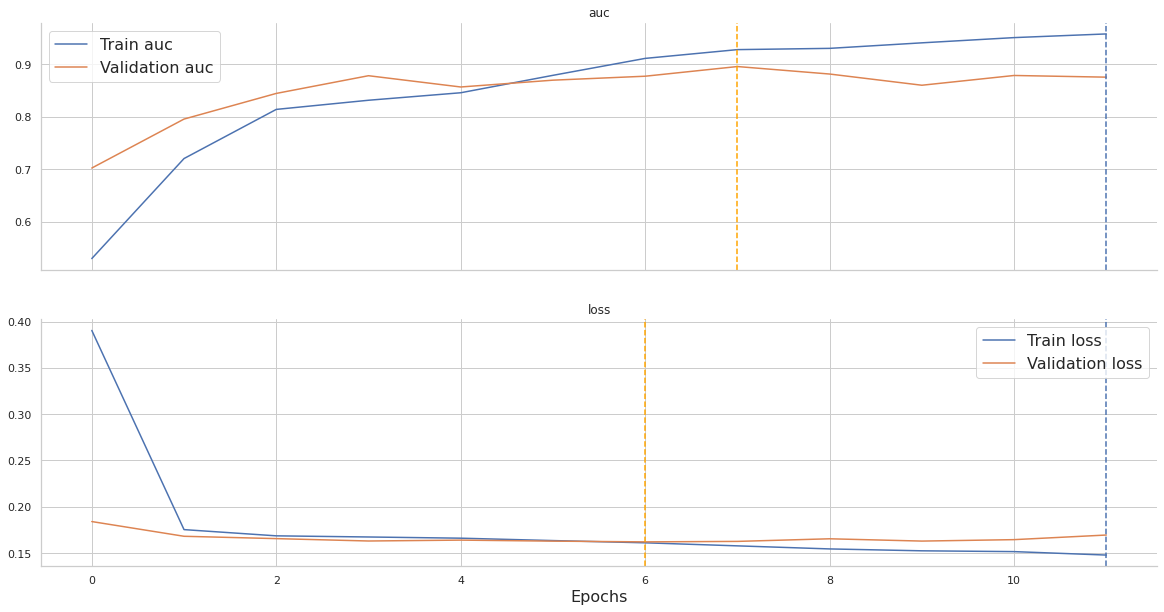

Fold: 2


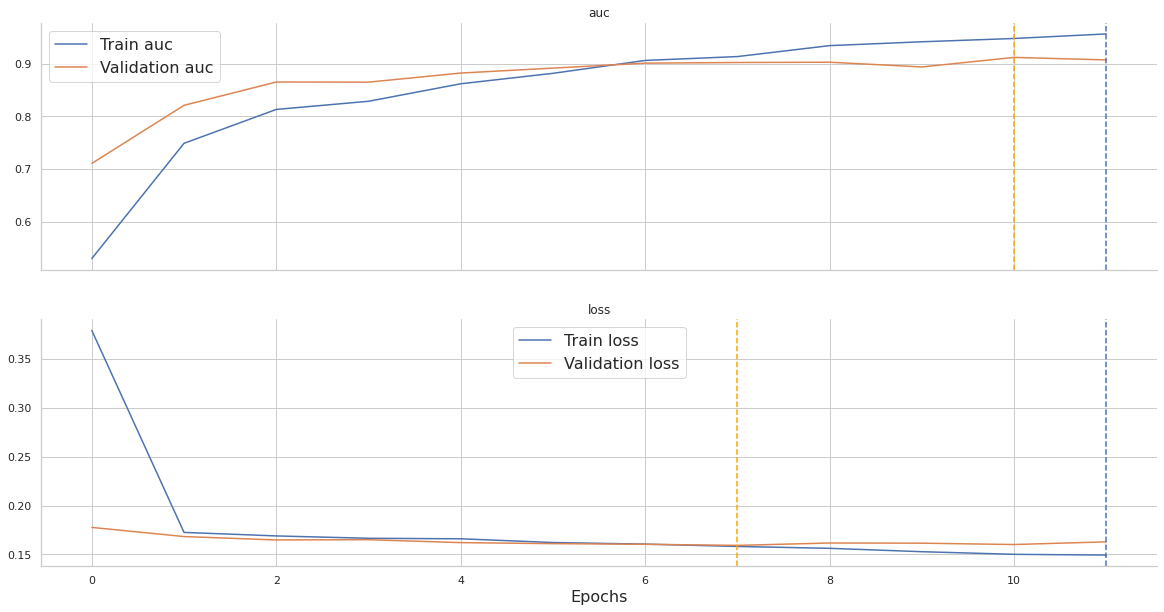

Fold: 3


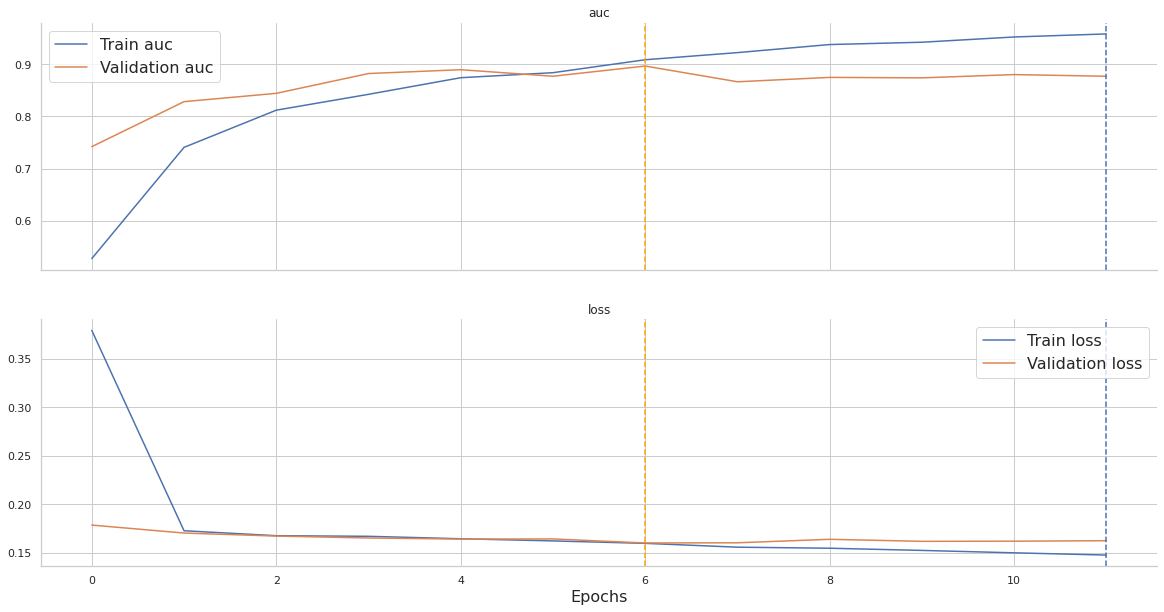

In [14]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

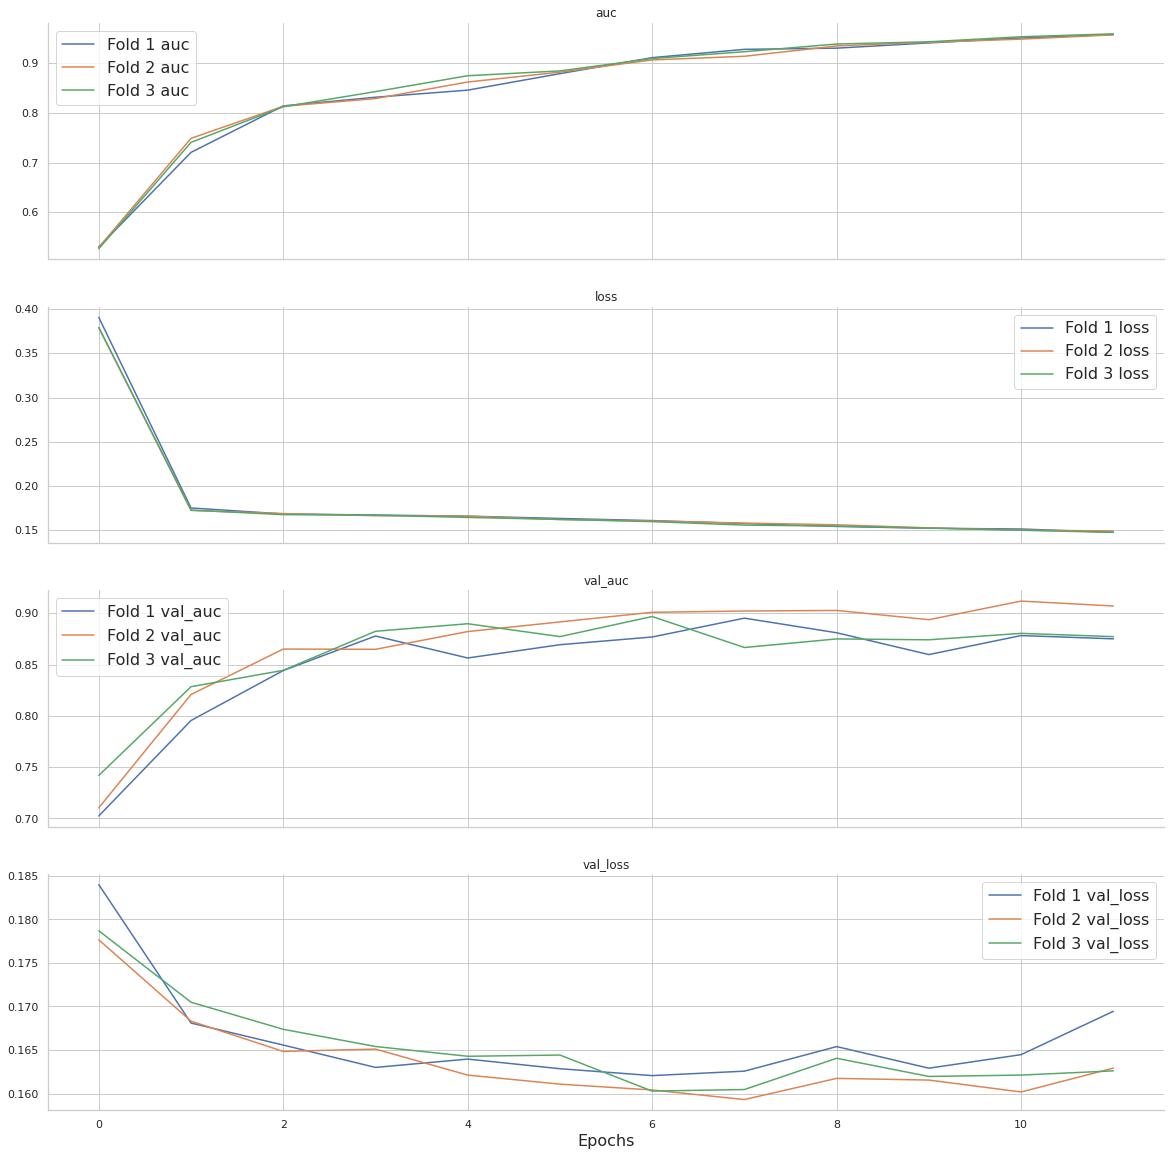

In [15]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [16]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.990460,0.886203,0.104257,0.990193,0.875802,0.989044,0.907068,0.992144,0.875741
Accuracy,0.993510,0.979747,0.013763,0.993720,0.979961,0.992792,0.978593,0.994018,0.980686
Precision,0.870386,0.378984,0.491403,0.865140,0.356322,0.846535,0.346667,0.899485,0.433962
Recall,0.743330,0.219921,0.523409,0.767494,0.219858,0.721519,0.236364,0.740977,0.203540
F1-score,0.801671,0.276706,0.524965,0.813397,0.271930,0.779043,0.281081,0.812573,0.277108
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


# Model evaluation by Subset

In [17]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.990460,0.886203,0.104257,0.990193,0.875802,0.989044,0.907068,0.992144,0.875741
male,0.992075,0.887261,0.104813,0.991636,0.871405,0.992842,0.913850,0.991746,0.876528
female,0.988056,0.877821,0.110235,0.987634,0.882304,0.983640,0.879410,0.992894,0.871749
head/neck,0.991514,0.890087,0.101426,0.991830,0.935465,0.991499,0.883094,0.991212,0.851703
upper extremity,0.989732,0.884822,0.104909,0.987279,0.856341,0.988205,0.897257,0.993711,0.900870
lower extremity,0.982183,0.845190,0.136993,0.981943,0.827472,0.979696,0.866009,0.984911,0.842088
torso,0.993329,0.907481,0.085847,0.993785,0.900183,0.991807,0.941316,0.994394,0.880946
0 <= age < 26,0.970736,0.752175,0.218560,0.976745,0.874825,0.942744,0.666473,0.992719,0.715228
26 <= age < 40,0.995085,0.843613,0.151472,0.993631,0.831470,0.996574,0.805164,0.995049,0.894205


# Model evaluation (best)

In [18]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.970015,0.893900,0.076114,0.958394,0.880691,0.976541,0.905142,0.975109,0.895868
Accuracy,0.985343,0.983180,0.002162,0.984824,0.983341,0.985546,0.983583,0.985657,0.982617
Precision,0.899314,0.721164,0.178150,0.902439,0.600000,0.912621,0.785714,0.882883,0.777778
Recall,0.191141,0.075259,0.115882,0.167043,0.063830,0.198312,0.100000,0.208068,0.061947
F1-score,0.314833,0.135853,0.178980,0.281905,0.115385,0.325823,0.177419,0.336770,0.114754
Support,462.666667,121.333333,341.333333,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.970015,0.893900,0.076114,0.958394,0.880691,0.976541,0.905142,0.975109,0.895868
male,0.973870,0.895446,0.078424,0.966084,0.887780,0.979566,0.896091,0.975959,0.902469
female,0.962822,0.885793,0.077029,0.943044,0.869290,0.971915,0.914595,0.973508,0.873494
head/neck,0.963652,0.891168,0.072484,0.950297,0.899767,0.976484,0.857019,0.964174,0.916718
upper extremity,0.969546,0.897557,0.071990,0.961271,0.881074,0.968416,0.901416,0.978952,0.910180
lower extremity,0.965050,0.865975,0.099075,0.956240,0.862445,0.967622,0.859311,0.971287,0.876167
torso,0.972556,0.906074,0.066482,0.959506,0.874198,0.981704,0.950589,0.976457,0.893434
0 <= age < 26,0.948511,0.770021,0.178490,0.943888,0.956993,0.938681,0.626450,0.962965,0.726619
26 <= age < 40,0.974564,0.845871,0.128693,0.960554,0.834942,0.991629,0.776073,0.971510,0.926599


# Confusion matrix

Fold: 1


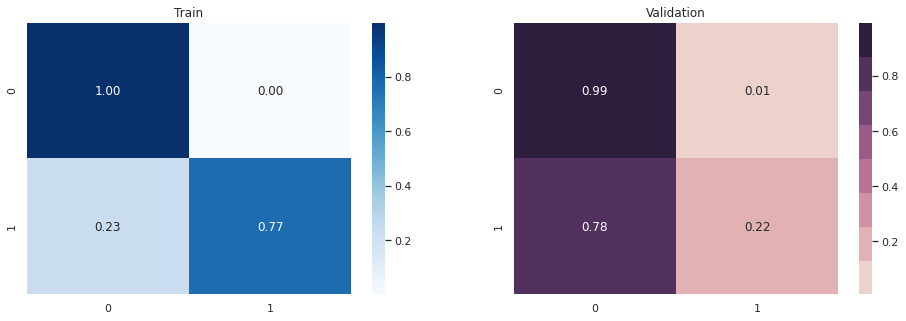

Fold: 2


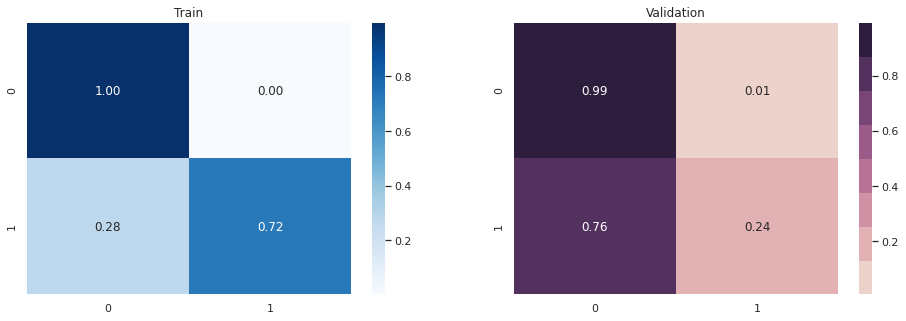

Fold: 3


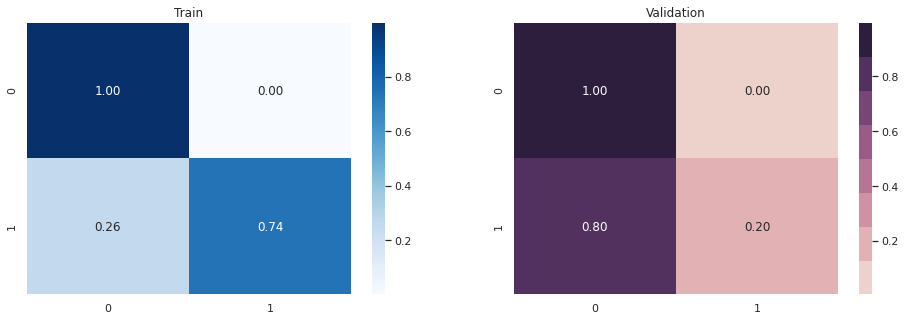

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 149
Train positive correct predictions: 149
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.012612,0.026815,0.020340,0.015906
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.018222,0.032824,0.028785,0.029503
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.017785,0.032941,0.026553,0.029431
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.014315,0.019577,0.036308,0.015691
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.016168,0.023663,0.025071,0.032106
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.014952,0.028861,0.022093,0.023805
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.030127,0.077461,0.041590,0.031586
7,ISIC_0075663,female,35.0,torso,unknown,0,0.010762,0.018216,0.016540,0.019052
8,ISIC_0075914,male,30.0,torso,unknown,0,0.018679,0.028876,0.032631,0.031888
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.021198,0.038730,0.027806,0.039454


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.258627,0.034306,0.515015,0.743815
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.353739,0.119269,0.825585,0.823839
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.071905,0.075582,0.250496,0.033446
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.240972,0.058557,0.570974,0.575328
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.387081,0.064726,0.957830,0.912848
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.361291,0.680229,0.543382,0.582844
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.347298,0.929852,0.236805,0.569830
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.416132,0.404586,0.902695,0.773378
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.364677,0.100485,0.843034,0.879867
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.194379,0.398828,0.515293,0.057774


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.593503,0.998506,0.982711,0.986296
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.527764,0.995445,0.709212,0.934161
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.588677,0.994989,0.960089,0.988307
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.579533,0.995271,0.965818,0.936577
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.548676,0.945395,0.944068,0.853919
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.580733,0.997492,0.968762,0.937414
2485,ISIC_0844312,male,75.0,head/neck,melanoma,1,0.534196,0.738315,0.968592,0.964073
2542,ISIC_0862745,female,75.0,head/neck,melanoma,1,0.579277,0.955412,0.950842,0.990131
2709,ISIC_0911264,male,65.0,lower extremity,melanoma,1,0.590677,0.993273,0.972150,0.987963
2753,ISIC_0924427,male,65.0,head/neck,melanoma,1,0.581778,0.995152,0.952214,0.961524


# Visualize test predictions

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 16|10966
Test predictions (last) 134|10848
Test predictions (tta) 11|10971
Test predictions (last tta) 110|10872
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.031980,0.030532,0.034710,0.031357
1,ISIC_0052349,male,40.0,lower extremity,0.026825,0.022985,0.025352,0.022643
2,ISIC_0058510,female,55.0,torso,0.030353,0.032758,0.028370,0.028434
3,ISIC_0073313,female,50.0,torso,0.030833,0.027158,0.031427,0.028435
4,ISIC_0073502,female,45.0,lower extremity,0.050602,0.020623,0.041321,0.028707
5,ISIC_0074618,male,50.0,lower extremity,0.037628,0.047218,0.040781,0.048419
6,ISIC_0076801,male,45.0,upper extremity,0.029128,0.030933,0.027896,0.030746
7,ISIC_0077586,male,50.0,lower extremity,0.047074,0.031799,0.047347,0.034918
8,ISIC_0082004,female,45.0,torso,0.038744,0.028510,0.051896,0.040678
9,ISIC_0082785,male,65.0,lower extremity,0.044469,0.036006,0.048581,0.034215


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
403,ISIC_0481105,male,80.0,torso,0.583333,0.957370,0.521442,0.902953
943,ISIC_0936377,male,65.0,head/neck,0.635111,0.886359,0.595419,0.798076
2116,ISIC_2002073,male,40.0,upper extremity,0.590860,0.961941,0.407033,0.821672
2195,ISIC_2078598,male,80.0,torso,0.604068,0.870758,0.584697,0.848993
2293,ISIC_2170268,female,80.0,upper extremity,0.537413,0.828191,0.569181,0.835182
2739,ISIC_2560699,male,70.0,torso,0.618754,0.974504,0.551438,0.944712
3045,ISIC_2839742,male,70.0,upper extremity,0.549807,0.917815,0.587889,0.894691
4332,ISIC_4000026,male,90.0,torso,0.527501,0.635171,0.540109,0.825230
4797,ISIC_4416545,male,70.0,torso,0.602187,0.904784,0.462582,0.731332
5412,ISIC_4965292,female,80.0,upper extremity,0.502383,0.523645,0.233804,0.347773


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.357383,0.717623,0.272918,0.646760
42,ISIC_0155983,male,70.0,torso,0.450060,0.850179,0.358492,0.639100
69,ISIC_0182213,female,80.0,head/neck,0.418278,0.733947,0.267658,0.558550
109,ISIC_0216447,male,80.0,head/neck,0.279651,0.522868,0.266276,0.478790
403,ISIC_0481105,male,80.0,torso,0.583333,0.957370,0.521442,0.902953
522,ISIC_0585534,male,70.0,head/neck,0.448498,0.823616,0.381504,0.556524
530,ISIC_0588352,male,60.0,lower extremity,0.283663,0.601191,0.366845,0.775375
552,ISIC_0606244,male,70.0,torso,0.237619,0.606223,0.201570,0.475817
764,ISIC_0775584,female,35.0,lower extremity,0.354763,0.750590,0.255151,0.371418
935,ISIC_0931237,male,70.0,upper extremity,0.203217,0.531882,0.134951,0.364622


# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.031980,0.030532,0.031256,0.034710,0.031357,0.033033
1,ISIC_0052349,0.026825,0.022985,0.024905,0.025352,0.022643,0.023998
2,ISIC_0058510,0.030353,0.032758,0.031555,0.028370,0.028434,0.028402
3,ISIC_0073313,0.030833,0.027158,0.028995,0.031427,0.028435,0.029931
4,ISIC_0073502,0.050602,0.020623,0.035612,0.041321,0.028707,0.035014
5,ISIC_0074618,0.037628,0.047218,0.042423,0.040781,0.048419,0.044600
6,ISIC_0076801,0.029128,0.030933,0.030030,0.027896,0.030746,0.029321
7,ISIC_0077586,0.047074,0.031799,0.039437,0.047347,0.034918,0.041133
8,ISIC_0082004,0.038744,0.028510,0.033627,0.051896,0.040678,0.046287
9,ISIC_0082785,0.044469,0.036006,0.040238,0.048581,0.034215,0.041398


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.048169,0.055118,0.051644,0.047395,0.053495,0.050445
std,0.047088,0.088095,0.065783,0.044601,0.081229,0.061343
min,0.015612,0.014024,0.016351,0.018315,0.014502,0.016651
25%,0.029713,0.028352,0.029334,0.029859,0.028598,0.029489
50%,0.035295,0.032958,0.034235,0.034714,0.032745,0.033806
75%,0.047260,0.043752,0.045862,0.046280,0.043398,0.045217
max,0.635111,0.974504,0.796629,0.595419,0.944712,0.748075
